# **Step2_AI면접관 Agent v2.0**


## **0. 미션**

### 미션③ : 고도화

* 1) 모듈 고도화 : 다음 항목에 대해서 조 상황에 맞게 선택적으로 고도화 합니다.
    * 사전 준비 단계 고도화 : Resume 요약, 전략도출 등 단계 고도화 시도
    * 답변에 대한 평가 고도화 : 평가가 적절한지 피드백 : reflection 노드 추가
    * 질문 생성 고도화 : 전략 별 참조 질문 Vector DB 구성
    * 인터뷰 진행 검토 : 기준에 따라 종료 여부 검토, 추가질문(같은 부문 심화 질문?, 새로운 부문 질문?)
    * 최종 평가 피드백 : 질문과 답변에 대한 최종 평가 보고서 제공

* 2) 웹 화면 연결(Gradio)


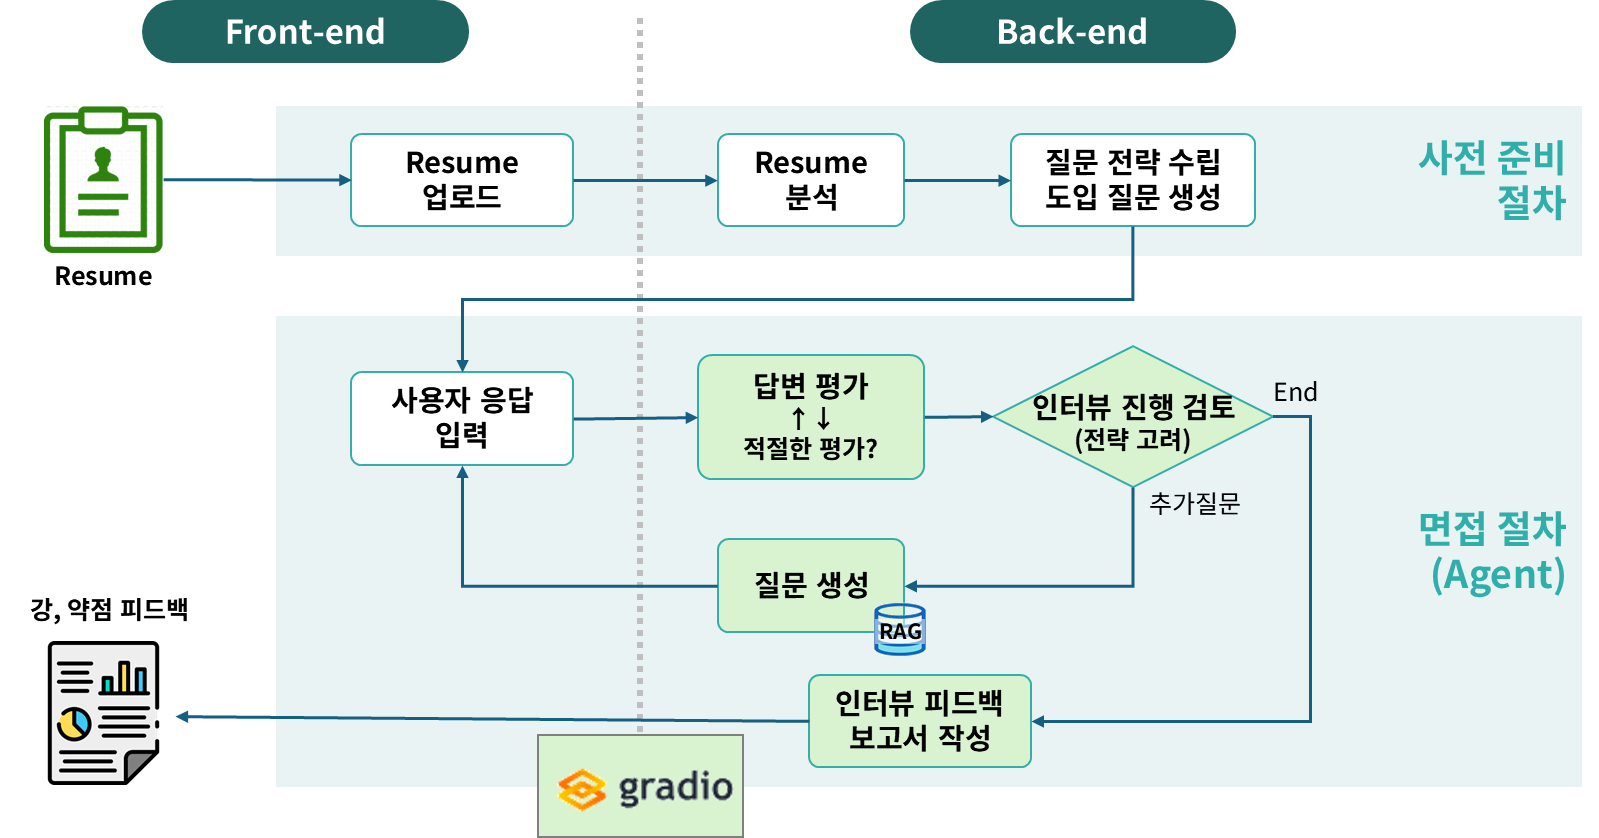

## **1. 환경준비**

### (1) 구글 드라이브

#### 1) 구글 드라이브 폴더 생성
* 새 폴더(project_genai)를 생성하고
* 제공 받은 파일을 업로드

#### 2) 구글 드라이브 연결

In [192]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### (2) 라이브러리

#### 1) 필요한 라이브러리 설치

In [193]:
!pip install langchain_openai langchain_core langchain-community -q
!pip install PyMuPDF
!pip install python-docx
!pip install -U langgraph
!pip install -U langchain-core langchain
!pip install langchain-hub

ERROR: Could not find a version that satisfies the requirement langchain-hub (from versions: none)
ERROR: No matching distribution found for langchain-hub


#### 2) 라이브러리 로딩

In [194]:
import pandas as pd
import numpy as np
import os
import ast
import fitz  # PyMuPDF
from docx import Document
import random
import openai
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from typing import Annotated, Literal, Sequence, TypedDict

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser, CommaSeparatedListOutputParser
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_community.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langgraph.graph import StateGraph, START, END
from langchain_core.output_parsers import JsonOutputParser

import json

from pydantic import BaseModel


### (3) OpenAI API Key 확인

In [195]:
def load_api_keys(filepath="api_key.txt"):
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if line and "=" in line:
                key, value = line.split("=", 1)
                os.environ[key.strip()] = value.strip()

path = '/content/drive/MyDrive/project2-2/project_genai/'
# API 키 로드 및 환경변수 설정
load_api_keys(path + 'api_key.txt')

⚠️ 아래 코드셀은, 실행해서 key가 제대로 보이는지 확인하고 삭제하세요.

In [ ]:
print(os.environ['OPENAI_API_KEY'][:30])

## **2. 미션③ : 고도화1**

* 미션① 고도화
    * Step1의 코드들을 붙어 넣고, 고도화가 필요하다면 코드를 개선합니다.
    * 개선 권장 부분
        * Resume 분석 : 요약 및 키워드 범위를 정하는 프롬프트 개선
        * 질문 전략 수립 : 3가지 부문 조정하고 질문 전략을 잘 뽑기 위한 프롬프트 개선

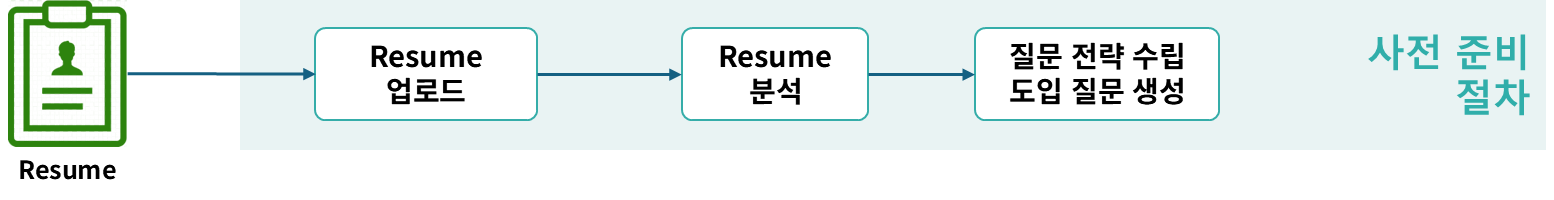

### (1) 파일 입력

In [197]:
def extract_text_from_file(file_path: str) -> str:
    ext = os.path.splitext(file_path)[1].lower()

    if ext == ".pdf":
        doc = fitz.open(file_path)
        text = "\n".join(page.get_text() for page in doc)
        doc.close()
        return text

    elif ext == ".docx":
        doc = Document(file_path)
        return "\n".join(p.text for p in doc.paragraphs if p.text.strip())

    else:
        raise ValueError("지원하지 않는 파일 형식입니다. PDF 또는 DOCX만 허용됩니다.")

In [198]:
# 파일에서 읽어 State 초기화
file_path = path + 'Resume_sample.pdf'
company_file_path = path + '채용공고.docx'

# 텍스트 추출
resume_text = extract_text_from_file(file_path)
target_company = extract_text_from_file(company_file_path)

print(resume_text)
print("="*30)
print(target_company)

<이력서> 
홍길동 (Gil-dong Hong) 
이메일: gildong.hong@example.com 
전화번호: 010-1234-5678 
학력 
- 한국대학교 전기정보공학부 학사 (2018.03 ~ 2022.02) 
  GPA: 3.91 / 4.3, 전공과목: 머신러닝, 데이터마이닝, 신호처리 
경력 
- KT, AI 연구소 인턴 (2021.07 ~ 2021.12) 
  • OCR 기반 문서 처리 시스템 고도화 
  • Tesseract + 딥러닝 후처리 파이프라인 설계 
  • 사내 법률문서 정제 정확도 12% 개선 
- 빅데이터 학생연합 (BDSA) 기술부장 (2020.03 ~ 2021.02) 
  • Python 기반 크롤러 및 Flask API 개발 
  • 공공데이터 기반 부동산 가격 예측 프로젝트 리드 
프로젝트 
- AI 면접관 시스템 개발 (졸업 과제) 
  • OpenAI GPT + Streamlit + FAISS 기반 질문-응답 시스템 구현 
  • 이력서 기반 질문 자동 생성 + 답변 피드백 제공 
- 딥러닝 기반 교통량 예측 (교과목 프로젝트) 
  • LSTM 기반 모델 + 서울시 교통데이터 
  • MAE 15% 이하로 개선 
기술 스택 
- Python, PyTorch, TensorFlow, OpenCV 
- MySQL, MongoDB, Git, Docker 

- 영어 (TOEIC 915, 영어면접 가능) 
수상 및 자격 
- SKT Big Data Challenge 2021 장려상 
- 정보처리기사 (2022.05 취득) 
기타 
- Github: github.com/gildong-ai 
- 블로그: blog.naver.com/gildong_dev 
 
 

<자기소개서> 
1. 본인 성격의 강/약점에 대해서 실제 사례를 포함하여 작성해 주세요. 
무엇인가 한번 빠져들면 해결하거나 성취할 때까지 모든 열정/노력을 쏟아붓는 성격으
로, 그 과정에서 큰 어려움이 발생하더라도 포기하지 않고 가능한 방법들을 찾아 해결하
는 편입니다

### (2) State 선언

In [199]:
from typing import TypedDict, List, Dict

class InterviewState(TypedDict):
    # 고정 정보
    resume_text: str
    target_company:str
    resume_summary: str
    resume_keywords: List[str] #(피드백) List[Dict[str, str]]
    target_company_keywords: List[str]

    question_strategy: Dict[str, Dict]

    # 인터뷰 로그
    current_question: str
    current_answer: str
    current_strategy: str
    conversation: List[Dict[str, str]]
    evaluation : List[Dict[str, str]]
    next_step : str

    #reflection
    reflection_status: str # def reflect에서 추가
    reflection_detail: Dict[str, str] # def reflect에서 추가
    last_evaluation: Dict[str, str] # def reflect에서 추가

    # 심층질문
    generate_count: str

In [200]:
# 테스트를 위한 초기 상태 구성
initial_state: InterviewState = {
    "resume_text": resume_text,
    "target_company": target_company,

    "resume_summary": '',
    "resume_keywords": [],
    "target_company_keywords": [],

    "question_strategy": {},

    "current_question": '',
    "current_answer": '',
    "current_strategy": '',
    "conversation": [],
    "evaluation": [],
    "next_step" : '',

    "generate_count" : "0",

    "reflection_status": "", # 수정: def reflect에서 추가
    "reflection_detail": [], # 수정: def reflect에서 추가
    "last_evaluation": [] # 수정: def reflect에서 추가

}

initial_state

{'resume_text': '<이력서> \n홍길동 (Gil-dong Hong) \n이메일: gildong.hong@example.com \n전화번호: 010-1234-5678 \n학력 \n- 한국대학교 전기정보공학부 학사 (2018.03 ~ 2022.02) \n  GPA: 3.91 / 4.3, 전공과목: 머신러닝, 데이터마이닝, 신호처리 \n경력 \n- KT, AI 연구소 인턴 (2021.07 ~ 2021.12) \n  • OCR 기반 문서 처리 시스템 고도화 \n  • Tesseract + 딥러닝 후처리 파이프라인 설계 \n  • 사내 법률문서 정제 정확도 12% 개선 \n- 빅데이터 학생연합 (BDSA) 기술부장 (2020.03 ~ 2021.02) \n  • Python 기반 크롤러 및 Flask API 개발 \n  • 공공데이터 기반 부동산 가격 예측 프로젝트 리드 \n프로젝트 \n- AI 면접관 시스템 개발 (졸업 과제) \n  • OpenAI GPT + Streamlit + FAISS 기반 질문-응답 시스템 구현 \n  • 이력서 기반 질문 자동 생성 + 답변 피드백 제공 \n- 딥러닝 기반 교통량 예측 (교과목 프로젝트) \n  • LSTM 기반 모델 + 서울시 교통데이터 \n  • MAE 15% 이하로 개선 \n기술 스택 \n- Python, PyTorch, TensorFlow, OpenCV \n- MySQL, MongoDB, Git, Docker \n\n- 영어 (TOEIC 915, 영어면접 가능) \n수상 및 자격 \n- SKT Big Data Challenge 2021 장려상 \n- 정보처리기사 (2022.05 취득) \n기타 \n- Github: github.com/gildong-ai \n- 블로그: blog.naver.com/gildong_dev \n \n \n\n<자기소개서> \n1. 본인 성격의 강/약점에 대해서 실제 사례를 포함하여 작성해 주세요. \n무엇인가 한번 빠져들면 해결하거나 성취할 때까지 모든 열정/노력을 쏟아붓는 성격으

### (3) Resume 분석

In [201]:
def analyze_resume(state: InterviewState) -> InterviewState:
    resume_text = state.get('resume_text')
    target_company = state.get('target_company')

    # 예외 처리: 이력서 없음
    if not resume_text or resume_text.strip() == "":
        return {
            **state,
            "resume_summary": "이력서 텍스트가 없습니다.",
            "resume_keywords": [],
            "target_company_keywords": [],
            "next_step": "end"
        }

    # 예외 처리: 지원 회사 없음
    if not target_company or target_company.strip() == "":
        return {
            **state,
            "resume_summary": "지원 회사 정보가 누락되었습니다.",
            "resume_keywords": [],
            "target_company_keywords": [],
            "next_step": "end"
        }


    # LLM 설정
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

    # 프롬프트 템플릿 정의
    keywords_prompt = ChatPromptTemplate.from_template("""
당신은 채용담당자이자 커리어 코치입니다.
아래의 이력서와 채용공고를 분석하여 핵심 요약과 키워드를 JSON 형식으로 반환하세요.

[이력서]
{resume_text}

[채용공고]
{target_company}

다음 형식으로 출력하세요:
{{
  "resume_summary": "이력서의 핵심 요약 (한 문단, 3~4문장)",
  "resume_keywords": ["키워드1", "키워드2", ..., "키워드10"],
  "target_company_keywords": ["키워드1", "키워드2", ..., "키워드10"]
}}
    """)

    # 체인 구성
    keywords_chain = keywords_prompt | llm | JsonOutputParser()

    # 실행
    result = keywords_chain.invoke({
        "resume_text": resume_text,
        "target_company": target_company
    })

    # 결과 추출
    resume_summary = result.get("resume_summary", "")
    resume_keywords = result.get("resume_keywords", [])
    target_company_keywords = result.get("target_company_keywords", [])

    # 상태 업데이트 후 반환
    return {
        **state,
        "resume_summary": resume_summary,
        "resume_keywords": resume_keywords,
        "target_company_keywords": target_company_keywords,
        "next_step": "generate_question_strategy"
    }

In [202]:
update_state = analyze_resume(initial_state)

In [203]:
print(update_state)

{'resume_text': '<이력서> \n홍길동 (Gil-dong Hong) \n이메일: gildong.hong@example.com \n전화번호: 010-1234-5678 \n학력 \n- 한국대학교 전기정보공학부 학사 (2018.03 ~ 2022.02) \n  GPA: 3.91 / 4.3, 전공과목: 머신러닝, 데이터마이닝, 신호처리 \n경력 \n- KT, AI 연구소 인턴 (2021.07 ~ 2021.12) \n  • OCR 기반 문서 처리 시스템 고도화 \n  • Tesseract + 딥러닝 후처리 파이프라인 설계 \n  • 사내 법률문서 정제 정확도 12% 개선 \n- 빅데이터 학생연합 (BDSA) 기술부장 (2020.03 ~ 2021.02) \n  • Python 기반 크롤러 및 Flask API 개발 \n  • 공공데이터 기반 부동산 가격 예측 프로젝트 리드 \n프로젝트 \n- AI 면접관 시스템 개발 (졸업 과제) \n  • OpenAI GPT + Streamlit + FAISS 기반 질문-응답 시스템 구현 \n  • 이력서 기반 질문 자동 생성 + 답변 피드백 제공 \n- 딥러닝 기반 교통량 예측 (교과목 프로젝트) \n  • LSTM 기반 모델 + 서울시 교통데이터 \n  • MAE 15% 이하로 개선 \n기술 스택 \n- Python, PyTorch, TensorFlow, OpenCV \n- MySQL, MongoDB, Git, Docker \n\n- 영어 (TOEIC 915, 영어면접 가능) \n수상 및 자격 \n- SKT Big Data Challenge 2021 장려상 \n- 정보처리기사 (2022.05 취득) \n기타 \n- Github: github.com/gildong-ai \n- 블로그: blog.naver.com/gildong_dev \n \n \n\n<자기소개서> \n1. 본인 성격의 강/약점에 대해서 실제 사례를 포함하여 작성해 주세요. \n무엇인가 한번 빠져들면 해결하거나 성취할 때까지 모든 열정/노력을 쏟아붓는 성격으

In [204]:
import pandas as pd

df1 = pd.DataFrame({
    "Resume Keywords": update_state["resume_keywords"],
    "Company Keywords": update_state["target_company_keywords"]
})
print(update_state["resume_summary"])
display(df1)

홍길동은 전기정보공학을 전공하며 머신러닝과 데이터마이닝에 대한 깊은 이해를 가진 신입 소프트웨어 엔지니어입니다. KT AI 연구소에서 인턴으로 OCR 기반 문서 처리 시스템을 고도화하며 실무 경험을 쌓았고, Python과 다양한 데이터베이스 기술에 능숙합니다. 또한, AI 면접관 시스템과 교통량 예측 프로젝트를 통해 실질적인 개발 경험을 보유하고 있으며, Git과 Docker를 활용한 협업 경험도 갖추고 있습니다.


,Resume Keywords,Company Keywords
0,전기정보공학,소프트웨어 엔지니어
1,머신러닝,서버 개발
2,데이터마이닝,RESTful API
3,Python,데이터베이스 설계
4,딥러닝,서비스 성능 개선
5,AI,DevOps
6,Git,코드 품질 향상
7,Docker,협업 능력
8,MySQL,문제 해결 능력
9,프로젝트 경험,AWS


### (4) 질문 전략 수립

In [205]:
def generate_question_strategy(state: InterviewState) -> InterviewState:

    resume_summary = state.get('resume_summary')
    resume_keywords = state.get('resume_keywords')
    target_company_keywords = state.get('target_company_keywords')


    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    parser = JsonOutputParser()


    prompt = ChatPromptTemplate.from_template("""
당신은 기업 인사팀의 면접관입니다.
지원자의 이력서 요약과 회사의 핵심 키워드를 참고하여 면접 질문 전략을 수립하세요.

[이력서 요약]
{resume_summary}

[지원자 핵심 키워드]
{resume_keywords}

[회사 핵심 키워드]
{target_company_keywords}

면접 질문 전략은 다음 세 가지 평가 분야를 기반으로 구성합니다:
1. 경력과 경험
2. 커뮤니케이션 능력
3. 문제해결력

각 분야별로 아래 형식으로 작성하세요:

{{
  "strategy_summary": "전체 전략 요약 (2~3문장)", #예시: “지원자는 항공 안전과 협업 경험을 기반으로 책임감 있는 업무 수행 역량을 보여주었습니다. 면접에서는 현장 대응력과 커뮤니케이션 중심으로 역량을 검증할 예정입니다.”
  "categories": [
    {{
      "category": "경력과 경험",
      "question_direction": "면접관이 어떤 관점으로 질문을 이끌어갈지에 대한 설명",
      "example_question": "예시 질문 2개"
    }},
    {{
      "category": "커뮤니케이션 능력",
      "question_direction": "면접관이 확인하려는 의도와 평가 포인트",
      "example_question": "예시 질문 2개"
    }},
    {{
      "category": "문제해결력",
      "question_direction": "지원자의 판단력, 책임감 등을 평가하기 위한 방향",
      "example_question": "예시 질문 2개"
    }}
  ]
}}
    """)

    # 체인 구성
    chain = prompt | llm | parser

    # 실행
    result = chain.invoke({
        "resume_summary": resume_summary,
        "resume_keywords": resume_keywords,
        "target_company_keywords": target_company_keywords
    })

    # 결과 추출
    strategy_summary = result.get("strategy_summary", "")
    categories = result.get("categories", [])

    strategy_dict = {
        "summary": strategy_summary,
        "categories": categories
    }

    # state 업데이트 후 반환
    return {
        **state,
        "question_strategy": strategy_dict,
        "next_step": "update_current_answer"
    }



In [206]:
output_state = generate_question_strategy(update_state)

In [207]:
df2 = pd.DataFrame(output_state["question_strategy"]["categories"])
display(df2)

,category,question_direction,example_question
0,경력과 경험,"지원자가 KT AI 연구소에서의 인턴 경험과 관련 프로젝트에서 어떤 역할을 했는지,...","[KT AI 연구소에서 인턴으로 일하면서 가장 도전적이었던 프로젝트는 무엇이었고, ..."
1,커뮤니케이션 능력,"팀 프로젝트에서의 협업 경험을 통해 지원자의 커뮤니케이션 능력과 팀워크를 평가하고,...","[Git과 Docker를 활용한 협업 경험에 대해 설명해 주시고, 팀원들과의 의견 ..."
2,문제해결력,지원자가 직면했던 문제를 어떻게 분석하고 해결했는지를 통해 문제 해결 능력과 판단력...,[OCR 기반 문서 처리 시스템을 고도화하는 과정에서 발생한 기술적 문제를 어떻게 ...


### (5) 하나로 묶기

In [208]:
def preProcessing_Interview(file_path: str) -> InterviewState:
    # 여기에 코드를 완성합니다.

    # 1. 텍스트 추출
    resume_text = extract_text_from_file(file_path)

    # 2. State 초기화
    initial_state: InterviewState = {

        "resume_text": resume_text,
        "target_company": target_company,

        "resume_summary": '',
        "resume_keywords": [],
        "target_company_keywords": [],

        "question_strategy": {},

        "current_question": '',
        "current_answer": '',
        "current_strategy": '',
        "conversation": [],
        "evaluation": [],
        "next_step" : '',

        "generate_count" : "",

        "reflection_status": "", # 수정: def reflect에서 추가
        "reflection_detail": {}, # 수정: def reflect에서 추가
        "last_evaluation": {} # 수정: def reflect에서 추가
    }

    # 3. 이력서 분석
    state = analyze_resume(initial_state)
    # ⭐️
    # analyze_resume이 실패하면 next_step이 'end'로 설정됨
    if state.get("next_step") == "end":
        print("오류: 이력서 분석 실패. 프로세스를 종료합니다.")
        return state

    # 4. 질문 전략 수립
    state = generate_question_strategy(state)

    # 5. 첫 번째 질문 선택
    # 경력 및 경험 첫 번째 예시 질문을 선택
    try:
        # strategy_dict['경력 및 경험']['예시 질문'][0]
        strategy = state.get("question_strategy", {})
        #### selected_question = strategy.get('면접 질문 전략', {}).get('경력 및 경험', {}).get('예시 질문', [])[0]
        cats = strategy.get("categories", [])
        selected_question = None
        selected_category = None
        # 전체 중 첫 유효 질문
        if not selected_question:
            for cat in cats:
                ex = (cat or {}).get("example_question")
                if isinstance(ex, list) and ex:
                    first = ex[0]
                    if isinstance(first, str) and first.strip():
                        selected_question = first.strip()
                        selected_category = (cat or {}).get("category", "경력과 경험")
                        break
                if isinstance(ex, str) and ex.strip():
                    selected_question = ex.strip()
                    selected_category = (cat or {}).get("category", "경력과 경험")
                    break

        # ⭐️
        if not selected_question:
            # 유효한 첫 질문을 찾지 못한 경우
            selected_question = "시스템 오류: 초기 질문 생성에 실패했습니다. 이력서를 다시 확인해주세요."
            print(f"오류: {selected_question}")
            # 이 상태를 받은 그래프가 즉시 종료하도록 'end'로 설정
            return {
                    **state,
                    "current_question": selected_question,
                    "current_strategy": "오류",
                    "next_step": "end" # 프로세스 중단 신호
                    }

    except Exception:
      selected_question = "자기소개 부탁드립니다."

    # return 코드는 제공합니다.
    return {
            **state,
            "current_question": selected_question,
            "current_strategy": "경력 및 경험"
            }

In [209]:
state = preProcessing_Interview(file_path)

# 3️⃣ 실행 결과 확인
print("\n=== 초기화된 InterviewState ===")
for key, value in state.items():
    print(f"{key}: {str(value)[:200]}")  # 너무 긴 항목은 앞부분만 출력


=== 초기화된 InterviewState ===
resume_text: <이력서> 
홍길동 (Gil-dong Hong) 
이메일: gildong.hong@example.com 
전화번호: 010-1234-5678 
학력 
- 한국대학교 전기정보공학부 학사 (2018.03 ~ 2022.02) 
  GPA: 3.91 / 4.3, 전공과목: 머신러닝, 데이터마이닝, 신호처리 
경력 
- KT, AI 연구소 인턴 (2021.07 ~ 
target_company: <기업> JD 
<직무> software engineer 
<주요업무> 
고도화된 웹/모바일 서비스의 서버 개발 및 운영 
RESTful API 및 데이터베이스 설계 
서비스 성능 개선 및 운영 자동화 
신규 서비스 및 기능의 API 서버 개발 
DB 모델링 및 데이터 관리 자동화 
코드 품질 향상을 위한 테스트 및 리팩토링 
DevOps 환경에서 배포 파
resume_summary: 홍길동은 전기정보공학을 전공한 신입 소프트웨어 엔지니어로, 머신러닝과 데이터마이닝에 대한 깊은 이해를 가지고 있습니다. KT AI 연구소에서 인턴으로 OCR 기반 문서 처리 시스템을 고도화하며 실무 경험을 쌓았고, Python과 다양한 데이터베이스 기술에 능숙합니다. 또한, AI 면접관 시스템과 교통량 예측 프로젝트를 통해 실질적인 개발 경험을 보유하고 있
resume_keywords: ['Python', '딥러닝', 'AI', 'OCR', '데이터베이스', 'Flask', 'Git', 'Docker', '프로젝트 리드', '문제 해결']
target_company_keywords: ['소프트웨어 엔지니어', 'RESTful API', '데이터베이스 설계', '서비스 성능 개선', 'DevOps', '코드 품질 향상', '협업 능력', '문제 해결 능력', 'AWS', 'Docker']
question_strategy: {'summary': '지원자는 머신러닝과 데이터마이닝에 대한 깊은 이해를 바탕으로 실무 경험을 쌓아온 신

## **3. 미션③ : 고도화2**

* 미션② 고도화
    * 답변에 대한 평가 고도화
        * 평가가 적절한지 피드백 : reflection 노드 추가
    * 질문 생성 고도화
        * 생성된 질문이 적절한지 피드백 : reflection 노드 추가
        * 전략 별 참조 질문 Vector DB 구성
    * 최종 평가 피드백
        * 질문과 답변에 대한 최종 평가 보고서 제공


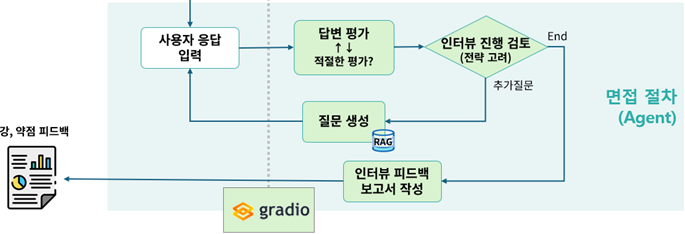

### (1) 답변 입력

In [210]:
def update_current_answer(state: InterviewState, user_answer: str) -> InterviewState:
    return {
        **state,
        "current_answer": user_answer.strip(),
        "next_step": "evaluate_answer"
    }

### (2) 답변 평가 : 고도화
* 고도화 제안
    * 평가가 적절한지 피드백 : reflection 노드 추가
    * conversation 저장이 중복되지 않도록 코드 조정

| 항목 | 설명 |
| ---- | ---- |
 목적 | 최근 평가가 적절한지 되돌아보고 판단 (보완 필요 여부 포함)
 입력 | current_question, current_answer, evaluation[-1]
 출력 | 판단 결과: "정상" or "재평가 필요" → state["reflection_status"] 저장
분기 구조 | "정상" → decide_next_step, "재평가 필요" → re_evaluate_answer



In [211]:
DEBUG_MODE = False  # ⚙️ True면 디버깅 로그 출력, False면 비활성화

In [212]:
def evaluate_answer(state: dict) -> dict:
    """면접자의 답변을 평가하고 점수화하는 핵심 함수"""

    # 🧩 변수 초기화
    current_question = state.get("current_question")
    current_answer = state.get("current_answer")

    conversation = state.get("conversation", [])
    evaluation = state.get("evaluation", [])

    # 🚨 예외 처리: 답변이 없을 경우
    if not current_question or not current_answer:
        return {
            **state,
            "evaluation_status": "ineligible",
            "evaluation_reason": (
                "지원자가 질문에 응답하지 않아 면접 평가를 진행할 수 없습니다. "
                "기본 커뮤니케이션 성의 기준을 충족하지 못했습니다."
            ),
            "next_step": "summarize",
        }

    # --------------------------------------
    # 🧠 LLM 및 파서 정의
    # --------------------------------------
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    parser = JsonOutputParser()

    # --------------------------------------
    # 💬 프롬프트 구성
    # --------------------------------------
    prompt = ChatPromptTemplate.from_template(
        """당신은 AI 면접관의 답변 평가 전문가입니다.
        질문과 답변을 바탕으로 아래 기준을 0~100점으로 채점하고, 가중치를 적용한 총점을 계산하세요.
        각 기준은 점수와 간단한 근거를 함께 주세요.

        [평가 기준 및 가중치]
        - 연관성 (0.30): 질문 의도에 정확히 부합하는가?
        - 구체성 (0.20): 구체적 사례/수치/근거가 있는가?
        - 영향/성과 (0.20): 결과 임팩트가 명확하고 측정 가능한가? (예: %, 비용/시간 절감, 매출 증대 등)
        - 역할·주도성 (0.20): 본인의 기여와 책임 범위가 뚜렷한가?
        - 커뮤니케이션(명료성) (0.10): 간결·논리·전문용어 사용이 적절한가?

        [출력 형식(JSON)]
        {{
          "기준": {{
            "연관성": {{ "점수": <0~100 정수>, "근거": "<문장>" }},
            "구체성": {{ "점수": <0~100 정수>, "근거": "<문장>" }},
            "영향/성과": {{ "점수": <0~100 정수>, "근거": "<문장>" }},
            "역할·주도성": {{ "점수": <0~100 정수>, "근거": "<문장>" }},
            "커뮤니케이션(명료성)": {{ "점수": <0~100 정수>, "근거": "<문장>" }}
          }},
          "가중합_점수": <0~100 정수>,
          "등급": "<상|중|하>",
          "핵심피드백": "<1~2문장 요점>",
          "개선가이드": ["<실행 팁 1>", "<실행 팁 2>", "<실행 팁 3>"]
        }}

        [등급 기준]
        - 81~100: 상
        - 51~80: 중
        - 0~50: 하

        --- 면접 질문 ---
        {question}

        --- 지원자 답변 ---
        {answer}
        """
    )

    # --------------------------------------
    # ⚙️ 체인 구성
    # --------------------------------------
    chain = prompt | llm | parser

    # --------------------------------------
    # 🪄 DEBUG 출력 (필요 시만)
    # --------------------------------------
    if DEBUG_MODE:
        print("\n🟢 [DEBUG-1] evaluate_answer 시작 ====================")
        print("질문:", current_question)
        print("답변:", current_answer[:120], "..." if len(current_answer) > 120 else "")
        print("------------------------------------------------------")

    # --------------------------------------
    # 🚀 LLM 평가 실행
    # --------------------------------------
    try:
        eval_result = chain.invoke({
            "question": current_question,
            "answer": current_answer,
        })
    except Exception as e:
        if DEBUG_MODE:
            print("❌ [DEBUG-2] LLM or Parser 오류 발생:", e)
        eval_result = {}
    else:
        if DEBUG_MODE:
            print("✅ [DEBUG-3] Raw eval_result 출력:")
            try:
                print(json.dumps(eval_result, indent=2, ensure_ascii=False))
            except Exception:
                print(eval_result)
        if not eval_result or "기준" not in eval_result:
            if DEBUG_MODE:
                print("⚠️ [DEBUG-4] 평가 결과가 비정상적입니다 (결측 발생 가능)")
                print("eval_result =", eval_result)
        else:
            if DEBUG_MODE:
                print("🧾 [DEBUG-5] 평가 키 정상 확인:", list(eval_result.keys()))
                print("======================================================\n")

    # --------------------------------------
    # 🔒 중복 평가 방지 로직
    # --------------------------------------
    existing_eval = next((e for e in evaluation if e["question"] == current_question), None)
    if existing_eval:
        existing_eval.update({"answer": current_answer, "evaluation": eval_result})
    else:
        conversation.append({"question": current_question, "answer": current_answer})
        evaluation.append({
            "question": current_question,
            "answer": current_answer,
            "evaluation": eval_result,
        })

    # --------------------------------------
    # 🔚 최종 반환 (다음 단계: reflect)
    # --------------------------------------
    return {
        **state,
        "conversation": conversation,
        "evaluation": evaluation,
        "last_evaluation": eval_result,
        "next_step": "reflect",
    }


In [213]:
def reflect(state: InterviewState) -> InterviewState:

    current_question = state.get("current_question", "")
    current_answer = state.get("current_answer", "")
    evaluation_list = state.get("evaluation", [])

    # 마지막 평가의 실제 E(dict)만 추출
    last_evaluation = None
    if evaluation_list:
        last_evaluation = evaluation_list[-1].get("evaluation")

    # 평가가 없으면 재평가 필요 → re_evaluate_answer 로 분기
    if not last_evaluation:
        return {
            **state,
            "reflection_status": "재평가 필요",
            "reflection_detail": {"사유": "평가(E) 없음"},
            "next_step": "re_evaluate_answer",
        }

    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    parser = JsonOutputParser()

    prompt = ChatPromptTemplate.from_template(
        """당신은 "감수관"입니다.
        A나 Q가 아닌, Q에 대한 A를 평가한 E가 적절했는지 평가합니다.
        [출력(JSON)]
        {{
          "평가_적절성_점수": (1~100의 수),
          "판정": "적절 | 부분 부적절 | 부적절",
          "핵심사유": "",
          "발견이슈": ["", ""],
          "과대과소_판정": "과대 | 과소 | 중립",
          "진단": {{
            "항목_존재": true,
            "점수근거_존재": true,
            "비례성_충족": true,
            "표현_적정": true
          }},
          "권장_수정": {{
            "평가_총점": (1~100의 수),
            "평가_코멘트": "E가 따를 보완 지시(E가 어떻게 하면 더 잘 평가할지)."
          }}
        }}
        --- Q(질문) ---
        {question}

        --- A(답변) ---
        {answer}

        --- E(LLM의 평가, JSON) ---
        {evaluation}
        """
    )

    chain = prompt | llm | parser

    # 1차 평가 dict -> 문자열(JSON)로 전달 (한글 유지)
    eval_str = json.dumps(last_evaluation, ensure_ascii=False)

    result = chain.invoke({
        "question": current_question,
        "answer": current_answer,
        "evaluation": eval_str
    })

    # 안전 파싱
    def to_int(x, default=0):
        try:
            return int(x)
        except Exception:
            return default

    adequacy = to_int(result.get("평가_적절성_점수", 0))
    verdict = (result.get("판정") or "").strip()

    # 판단 규칙: 점수 70+ 또는 판정 "적절"이면 정상
    is_ok = (adequacy >= 70) or (verdict == "적절")
    print(adequacy)
    if not is_ok:
        # 재평가 노드로 이동
        return {
            **state,
            "reflection_status": "재평가 필요",
            "reflection_detail": result,
            "next_step": "re_evaluate_answer"
        }

    # 정상 → 다음 단계
    return {
        **state,
        "reflection_status": "정상",
        "reflection_detail": result,
        "next_step": "decide_next_step"
    }

In [214]:
def re_evaluate_answer(state: InterviewState) -> InterviewState:
    # 여기에 코드를 완성합니다.
    current_question = state.get("current_question")
    current_answer = state.get("current_answer")

    conversation = state.get("conversation", [])
    evaluation = state.get("evaluation", [])

    # evaluate_answer과의 차이점: reflect가 저장한 리포트 추가
    reflection_detail = state.get("reflection_detail", [])

    # LLM
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    parser = JsonOutputParser()

    # 프롬프트
    # 프롬프트에 점수 및 기준 추가
    prompt = ChatPromptTemplate.from_template(
        """당신은 AI 면접관의 재평가자입니다.
        질문과 답변을 바탕으로 아래 기준을 0~100점으로 채점하고, 가중치를 적용한 총점을 계산하세요.
        각 기준은 점수와 간단한 근거를 함께 주세요.
        단, 아래의 감수 리포트를 반영하세요.

        [평가 기준 및 가중치]
        - 연관성 (0.30): 질문 의도에 정확히 부합하는가?
        - 구체성 (0.20): 구체적 사례/수치/근거가 있는가?
        - 영향/성과 (0.20): 결과 임팩트가 명확하고 측정 가능한가? (예: %, 비용/시간 절감, 매출 증대 등)
        - 역할·주도성 (0.20): 본인의 기여와 책임 범위가 뚜렷한가?
        - 커뮤니케이션(명료성) (0.10): 간결·논리·전문용어 사용이 적절한가?

        [감수 리포트(반영할 지적사항)]
        {reflection_detail}

        [출력 형식(JSON)]
        {{
          "기준": {{
            "연관성": {{ "점수": <0~100 정수>, "근거": "<문장>" }},
            "구체성": {{ "점수": <0~100 정수>, "근거": "<문장>" }},
            "영향/성과": {{ "점수": <0~100 정수>, "근거": "<문장>" }},
            "역할·주도성": {{ "점수": <0~100 정수>, "근거": "<문장>" }},
            "커뮤니케이션(명료성)": {{ "점수": <0~100 정수>, "근거": "<문장>" }}
          }},
          "가중합_점수": <0~100 정수>,   // 위 가중치로 계산
          "등급": "<상|중|하>",
          "핵심피드백": "<1~2문장 요점>",
          "개선가이드": ["<실행 팁 1>", "<실행 팁 2>", "<실행 팁 3>"]
        }}

        [등급 기준]
        - 81~100: 상
        - 51~80: 중
        - 0~50: 하

        --- 면접 질문 ---
        {question}

        --- 지원자 답변 ---
        {answer}
        """
    )

    chain = prompt | llm | parser

    # LLM 호출하여 평가 결과 받기 (결과는 dict)
    eval_result = chain.invoke({
        "question": current_question,
        "answer": current_answer,
        "reflection_detail": json.dumps(reflection_detail, ensure_ascii=False)
    })

    # 대화 로그 append 없음 (재평가는 같은 턴의 평가만 교체/추가)
    # 마지막 평가를 재평가로 교체하는 패턴 권장
    if evaluation and evaluation[-1].get("question") == current_question and evaluation[-1].get("answer") == current_answer:
        evaluation[-1]["evaluation"] = eval_result
    else:
        evaluation.append({
            "question": current_question,
            "answer": current_answer,
            "evaluation": eval_result,
        })

    # return 코드는 제공합니다.

    return {
        **state,
        "evaluation": evaluation,
    }

### (3) 인터뷰 진행 검토 : 고도화

* 조건
    * 모든 전략 영역을 한 번 이상 커버했으면 → "end"
    * 전체 질문&답변이 5번 진행되었으면 → "end"  (인터뷰가 너무 길어지는 것 방지)
    * 가장 최근 평가에 "하"가 있다면 → additional_question (현재 전략 유지)
    * 최근 평가가 "상" or "중" → next_strategy (다음 전략으로 전환)

In [215]:
# ⭐️ (신규 셀) 셀 42와 셀 43(decide_next_step 실행 셀) 사이에 추가하세요.

def get_next_question_from_queue(state: InterviewState) -> InterviewState:
    """question_queue에서 다음 질문을 꺼내 current_question으로 설정합니다."""

    question_queue = state.get("question_queue", [])

    if not question_queue:
        # 큐가 비었는데 이 노드가 호출된 것은 오류. 다음 주제로 넘김.
        return {**state, "next_step": "next_topic"}

    # 1. 큐에서 다음 질문을 꺼냄
    next_question = question_queue.pop(0)

    return {
        **state,
        "current_question": next_question,
        "question_queue": question_queue, # 업데이트된 큐 (하나 빠진 상태)
        "current_answer": ""              # 답변란 비우기
    }

In [216]:
def decide_next_step(state: InterviewState) -> InterviewState:
    # 여기에 코드를 완성합니다.

    # 현재까지의 대화 기록 확인
    conversation_count = len(state.get("conversation", []))
    evaluation = state.get("evaluation", [])

    # ⭐️ (추가) 큐와 남은 주제 리스트를 가져옵니다.
    question_queue = state.get("question_queue", [])
    remaining_topics = state.get("remaining_topics", [])

    # 방금 평가가 끝난 최신 항목
    if not evaluation:
        return {**state, "next_step": "generate"}

    last_eval_item = evaluation[-1]
    last_evaluation_dict = last_eval_item.get("evaluation", {})
    eval_summary = f"연관성: {last_evaluation_dict.get('연관성', '중')}, 구체성: {last_evaluation_dict.get('구체성', '중')}"

    # LLM, 프롬프트, 파서 정의
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    parser = StrOutputParser()

    # ⭐️ (프롬프트 수정) [결정 규칙]과 입력 변수 수정
    prompt = ChatPromptTemplate.from_template(
      """당신은 AI 면접 진행 관리자입니다.
      지원자의 최근 답변 평가, 남은 예시 질문, 남은 주제 목록을 보고 다음 행동을 결정해 주세요.

      [결정 규칙]
      1. (최우선) 현재 대화 횟수는 {count}인데 최대 5번을 넘으면 안됩니다. 5번 이상이면 'end'를 반환하세요.
      2. (2순위) 답변 평가가 '하' 이면: 이 주제를 심화하기 위해 'generate'를 반환합니다.
      3. (3순위) "현재 주제의 남은 예시 질문"이 [있음]이면: 'next_question'을 반환합니다.
      4. (4순위) 답변 평가가 '상' 또는 '중'이면: 다음 주제로 넘어가기 위해 'next_topic'을 반환합니다. (이 규칙은 2, 3번이 아닐 때만 실행됩니다)
      5. 만약 4번에 의해 'next_topic'을 반환해야 하는데 "남은 주제 목록"이 [없음]이라면, 'end'를 반환합니다.

      당신의 결정은 오직 'next_question', 'generate', 'next_topic', 'end' 네 단어 중 하나여야 합니다.

      --- [현재 주제의 남은 예시 질문] ---
      [{queue_status}]

      --- [최근 답변 평가 ('상,중,하'제)] ---
      {evaluation}

      --- [남은 주제 목록] ---
      [{remaining}]

      [당신의 결정 (next_question/generate/next_topic/end)]:
      """
  )

    chain = prompt | llm | parser

    # ⭐️ (invoke 수정) 'queue_status' 변수 추가
    next_step = chain.invoke({
        "count": conversation_count,
        "queue_status": "있음" if question_queue else "없음", # 큐 상태를 LLM에게 전달
        "evaluation": eval_summary,
        "remaining": ", ".join(remaining_topics) if remaining_topics else "없음"
    }).strip().lower()

    # ⭐️ (응답 정제 수정) 'next_question' 추가
    if "end" in next_step:
        next_step = "end"
    elif "next_topic" in next_step:
        if not remaining_topics:
            next_step = "end"
        else:
            next_step = "next_topic"
    elif "generate" in next_step:
         next_step = "generate"
    elif "next_question" in next_step:
         # 큐가 비어있는데 next_question을 반환한 LLM의 실수를 방지
         if not question_queue:
             next_step = "generate" # 큐가 비었으면 심화 질문으로 유도
         else:
             next_step = "next_question"
    else:
         next_step = "generate" # 기본값


    # return 코드는 제공합니다.
    return {
        **state,
        "next_step": next_step
    }

In [217]:
def next_topic_question(state: InterviewState) -> InterviewState:
    """'remaining_topics'에서 다음 주제를 꺼내고, 그 주제의 첫 번째 예시 질문을 current_question으로 설정합니다."""

    remaining_topics = state.get("remaining_topics", [])
    strategy = state.get("question_strategy", {})

    if not remaining_topics:
        # 이중 안전장치: 남은 주제가 없으면 종료
        return {**state, "next_step": "end", "current_question": "면접을 종료합니다."}

    # 1. '남은 주제' 리스트에서 다음 주제를 하나 꺼냅니다 (pop)
    current_topic = remaining_topics.pop(0)

    # 2. 해당 주제의 첫 번째 예시 질문을 가져옵니다.
    try:
        strategy_main = strategy.get("면접 질문 전략", strategy)
        selected_question = strategy.get(current_topic, {}).get("예시 질문", [])[0]
        if not selected_question:
            selected_question = f"{current_topic}에 대해 말씀해 주세요."
    except Exception:
        selected_question = f"{current_topic}에 대해 말씀해 주세요."

    return {
        **state,
        "current_question": selected_question,     # <- 새 주제의 질문으로 교체
        "current_strategy": current_topic,         # <- 현재 주제 업데이트
        "remaining_topics": remaining_topics,  # <- 하나가 빠진 '남은 주제' 리스트로 업데이트
        "current_answer": ""                       # 답변란 비우기
    }

### (4) 질문 생성 : 고도화

* 요건
    * 현재 generate_question()은 기존 전략 예시 질문과 최근 답변을 기반으로 심화 질문 생성
    * 여기에 Chroma Vector DB를 추가해서, 유사 질문 3개 정도를 LLM 프롬프트에 참조 정보로 포함
    * 질문은 여전히 LLM이 생성, 유사 질문은 참고로만 사용

In [218]:
def generate_question(state: InterviewState) -> InterviewState:
    resume_summary = state.get("resume_summary", "")
    resume_keywords = state.get("resume_keywords", [])
    current_strategy = state.get("current_strategy", {})
    conversation = state.get("conversation", [])
    evaluation = state.get("evaluation", [])
    generate_count = int(state.get("generate_count", 0))

    # 대화 기록 정리
    history_str = ""
    for i, (conv, eval_item) in enumerate(zip(conversation, evaluation)):
        history_str += f"\n--- 질문 {i+1} ---\n"
        history_str += f"Q: {conv['question']}\n"
        history_str += f"A: {conv['answer']}\n"
        history_str += f"평가: {json.dumps(eval_item['evaluation'], ensure_ascii=False)}\n"

    if not history_str:
        history_str = "아직 면접이 시작되지 않았습니다."

    # 심층 질문 생성 횟수 제한
    if generate_count > 5:
        return {
            **state,
            "current_question": "심층 질문이 완료되었습니다. 다음 주제로 이동하세요.",
            "current_answer": "",
            "generate_count": str(0)
        }

    # 심층 질문 단계 설정
    if generate_count == 0:
        depth_comment = "이력서 내용을 기반으로 첫 번째 기본 질문을 생성하세요."
    elif generate_count == 1:
        depth_comment = "첫 번째 답변을 바탕으로, 기술적 이해도를 더 확인할 수 있는 심화 질문을 생성하세요."
    elif generate_count == 2:
        depth_comment = "두 번째 답변의 논리나 경험의 구체성을 검증할 수 있는 더 깊은 질문을 생성하세요."
    else:
        depth_comment = "지금까지의 답변을 종합하여, 지원자의 사고력·문제 해결력·가치관을 탐구할 수 있는 고난도 질문을 생성하세요."

    # Chroma Vector DB 연동
    try:
        # Chroma DB 로드 (없으면 예외 처리)
        embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
        db_path = "./chroma_db"
        if not os.path.exists(db_path):
            #raise FileNotFoundError(f"Chroma DB 폴더가 없습니다: {db_path}")
            os.makedirs(db_path)
            print("새로운 chroma_DB 폴더를 생성합니다.")

        db = Chroma.from_texts(texts = [depth_comment], persist_directory=db_path)

        # 현재 문맥으로 유사 질문 검색
        query_text = f"{resume_summary}\n{history_str}"
        similar_docs = db.similarity_search(query_text, k=3)
        similar_questions = "\n".join([f"- {doc.page_content}" for doc in similar_docs])
    except Exception as e:
        similar_questions = "유사 질문 정보를 불러올 수 없습니다."
        print(f"[Chroma 검색 오류] {e}")

    # LLM 프롬프트 구성
    prompt = ChatPromptTemplate.from_template(
        """당신은 전문 AI 면접관입니다.
        아래 정보를 참고하여 지원자에게 **새로운 심층 질문**을 하나만 생성하세요.

        [참고 정보: 기존 면접 질문(유사도 높은 3개)]
        {similar_questions}

        [규칙]
        1. 위 유사 질문들과 **겹치지 않는 새로운 질문**을 만들어야 합니다.
        2. 지원자의 답변 평가를 고려해 사고력, 문제해결력, 가치관을 탐색하세요.
        3. 질문은 한 문장으로, 명확하고 간결하게 작성하세요.
        4. {depth_comment}

        --- [지원자 이력서 요약] ---
        {summary}

        --- [핵심 키워드] ---
        {keywords}

        --- [면접 전략] ---
        {strategy}

        --- [지금까지의 면접 기록 (질문, 답변, 평가)] ---
        {history}

        ---
        [다음 심층 질문 (오직 한 문장)]:
        """
    )

    # LLM 체인 실행
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)
    chain = prompt | llm

    response = chain.invoke({
        "summary": resume_summary,
        "keywords": ", ".join(resume_keywords),
        "strategy": json.dumps(current_strategy, ensure_ascii=False),
        "history": history_str,
        "depth_comment": depth_comment,
        "similar_questions": similar_questions
    })

    # 상태 업데이트
    return {
        **state,
        "current_question": response.content.strip(),
        "current_answer": "",
        "generate_count": str(generate_count + 1)
    }

### (5) 인터뷰 피드백 보고서 : 고도화


* 제안
    * 전략별 요약 : 각 전략 영역별로 답변 스타일, 강점/약점 정리
    * 종합 피드백 : 전체 인터뷰의 인상, 강점, 보완점
    * 형식 : 구조화된 텍스트 (분야별 블록 + 전체 종합 평가)
* 입력으로 활용할 요소
    * state["conversation"]       # 질문/답변 리스트
    * state["evaluation"]         # 질문별 평가 (연관성, 구체성)
    * state["question_strategy"]  # 전략 분류용

In [219]:
def summarize_interview(state: InterviewState) -> InterviewState:

    print("== AI 면접 최종 피드백 보고서 ==")

    # 1. 기본 정보 출력
    print("\n[이력서 요약]")
    print(state.get("resume_summary", "요약 정보 없음"))

    print("\n[핵심 키워드]")
    print(", ".join(state.get("resume_keywords", [])))

    target_company = state.get("target_company", "")
    if target_company:
        print(f"\n[지원 회사] {target_company}")

    conversation = state.get("conversation", [])
    evaluation = state.get("evaluation", [])

    if not conversation or not evaluation:
        print("\n면접 기록이 없습니다.")
        return state

    # 2. 각 질문별 상세 내역
    print("\n== 면접 상세 내역 ==")

    for i, (conv, eval_item) in enumerate(zip(conversation, evaluation), 1):
        question = conv.get("question", "질문 없음")
        answer = conv.get("answer", "답변 없음")
        eval_dict = eval_item.get("evaluation", {})

        print(f"\n[질문 {i}]")
        print(f"Q: {question}")
        print(f"\n[답변]")
        print(f"A: {answer}")
        print(f"\n[평가]")

        criteria = eval_dict.get("기준", {})
        if criteria:
            for criterion_name, criterion_value in criteria.items():
                score = criterion_value.get("점수", "N/A")
                print(f"  - {criterion_name}: {score}점")

        weighted_score = eval_dict.get("가중합_점수", "N/A")
        grade = eval_dict.get("등급", "N/A")
        print(f"  - 가중합 점수: {weighted_score}점 (등급: {grade})")

        feedback = eval_dict.get("핵심피드백", "")
        if feedback:
            print(f"  - 핵심피드백: {feedback}")

        print("-" * 60)

    # 3. 구체적인 종합 평가 (LLM)
    print("\n== 종합 평가 ==")

    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

    interview_text = ""
    for i, (conv, eval_item) in enumerate(zip(conversation, evaluation), 1):
        interview_text += f"\n[질문 {i}]\n"
        interview_text += f"Q: {conv['question']}\n"
        interview_text += f"A: {conv['answer']}\n"
        interview_text += f"평가: {eval_item['evaluation']}\n"

    comprehensive_prompt = ChatPromptTemplate.from_template(
        """당신은 전문 채용 컨설턴트입니다.
        다음 면접 내용을 바탕으로 **구체적이고 실질적인** 종합 평가를 작성하세요.

        **이력서 요약:**
        {resume_summary}

        **면접 기록:**
        {interview_text}

        **다음 형식으로 구체적으로 작성하세요:**

        1. 전체 인상 (2-3줄)
        - 이 지원자의 가장 큰 특징을 한 문장으로
        - 면접 전반에 대한 총평

        2. 강점 (구체적으로 3가지)
        - 각 강점마다 실제 답변 예시를 인용하여 설명
        - 왜 강점인지 명확한 근거 제시

        3. 약점 (구체적으로 3가지)
        - 각 약점마다 어떤 답변에서 드러났는지 구체적으로 지적
        - 어떤 점이 부족했는지 명확히 설명

        4. 개선 방안 (실질적으로 3가지)
        - 각 약점에 대한 구체적인 개선 액션 아이템
        - "~해야 합니다" 보다는 "~하세요" 형식으로 실행 가능하게

        **중요: 추상적이고 일반적인 평가가 아닌, 이 지원자의 실제 답변을 근거로 한 구체적인 피드백을 작성하세요.**
        """
    )

    comprehensive_chain = comprehensive_prompt | llm | StrOutputParser()
    comprehensive_feedback = comprehensive_chain.invoke({
        "resume_summary": state.get("resume_summary", ""),
        "interview_text": interview_text
    })

    print(comprehensive_feedback)

    # 4. 인터뷰 횟수 반영 합격 가능성 분석
    print("\n== 모의 합격 가능성 분석 ==")

    interview_count = len(conversation)

    # 점수 계산
    weighted_scores = []
    grades = []

    for eval_item in evaluation:
        eval_dict = eval_item.get("evaluation", {})
        weighted_score = eval_dict.get("가중합_점수", 0)
        grade = eval_dict.get("등급", "중")

        weighted_scores.append(weighted_score)
        grades.append(grade)

    # 평균 점수 계산
    avg_score = sum(weighted_scores) / len(weighted_scores) if weighted_scores else 0

    # 등급별 개수 계산
    excellence_count = grades.count("상")
    good_count = grades.count("중")
    poor_count = grades.count("하")

    print(f"\n[면접 평가 점수]")
    print(f"평균 가중합 점수: {avg_score:.1f}점")
    print(f"  - 상 등급: {excellence_count}개")
    print(f"  - 중 등급: {good_count}개")
    print(f"  - 하 등급: {poor_count}개")

    # 면접 횟수 보너스
    print(f"\n[면접 진행 횟수] {interview_count}회")

    if interview_count >= 5:
        count_bonus = 10
        count_comment = "심층 면접을 통해 지원자를 충분히 검증했습니다."
    elif interview_count >= 4:
        count_bonus = 5
        count_comment = "적절한 횟수의 면접이 진행되었습니다."
    else:
        count_bonus = 0
        count_comment = "기본 면접이 진행되었습니다."

    print(f"{count_comment}")
    if count_bonus > 0:
        print(f"  >> 면접 횟수 보너스: +{count_bonus}점")

    # 최종 점수 계산
    final_score = min(avg_score + count_bonus, 100)

    # 합격 가능성 판단
    if final_score >= 85:
        possibility = "매우 높음"
        probability = "85% 이상"
        comment = "대부분의 질문에 우수한 답변을 하였고, 충분한 검증이 이루어졌습니다."
    elif final_score >= 70:
        possibility = "높음"
        probability = "70-85%"
        comment = "전반적으로 좋은 평가를 받았으나, 일부 개선이 필요합니다."
    elif final_score >= 55:
        possibility = "보통"
        probability = "50-70%"
        comment = "기본은 갖췄으나, 경쟁력을 높이려면 보완이 필요합니다."
    else:
        possibility = "낮음"
        probability = "50% 미만"
        comment = "여러 영역에서 개선이 필요합니다."

    print(f"\n[합격 가능성] {possibility}")
    print(f"[예상 합격 확률] {probability}")
    if count_bonus > 0:
        print(f"  (평균 {avg_score:.1f}점 + 면접 횟수 보너스 {count_bonus}점 = {final_score:.1f}점)")
    else:
        print(f"  (평균 {avg_score:.1f}점)")
    print(f"\n{comment}")

    # ========================================
    # 시각화 (경로 및 한글 문제 해결)
    # ========================================
    print("\n== 점수 시각화 ==")

    try:
        import matplotlib.pyplot as plt
        import matplotlib
        import os
        matplotlib.use('Agg')

        # 저장 경로 설정 (Colab 환경 고려)
        save_dir = '/content'  # Colab 기본 경로
        if not os.path.exists(save_dir):
            save_dir = '.'  # 현재 디렉토리

        save_path = os.path.join(save_dir, 'interview_scores.png')

        # 그래프 생성
        plt.figure(figsize=(10, 6))

        # 한글 대신 영어 레이블 사용
        questions = [f"Q{i+1}" for i in range(len(weighted_scores))]

        # 등급별 색상
        colors = []
        for g in grades:
            if g == "상":
                colors.append('green')
            elif g == "중":
                colors.append('orange')
            else:
                colors.append('red')

        # 막대 그래프
        bars = plt.bar(questions, weighted_scores, color=colors, alpha=0.7,
                       edgecolor='black', linewidth=1.5)

        # 평균선
        plt.axhline(y=avg_score, color='blue', linestyle='--', linewidth=2,
                    label=f'Average: {avg_score:.1f}')

        # 최종 점수선
        if count_bonus > 0:
            plt.axhline(y=final_score, color='purple', linestyle='--', linewidth=2,
                        label=f'Final: {final_score:.1f}')

        # 그래프 꾸미기
        plt.xlabel('Questions', fontsize=12, fontweight='bold')
        plt.ylabel('Weighted Score', fontsize=12, fontweight='bold')
        plt.title('Interview Score Analysis', fontsize=14, fontweight='bold')
        plt.ylim(0, 100)
        plt.legend(fontsize=10)
        plt.grid(axis='y', alpha=0.3)

        # 막대 위에 점수 표시
        for bar, score in zip(bars, weighted_scores):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{score:.1f}', ha='center', va='bottom',
                    fontsize=10, fontweight='bold')

        # 저장
        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()

        print(f"시각화 완료: {save_path}")

        # Colab이면 이미지 표시
        try:
            from IPython.display import Image, display
            display(Image(save_path))
        except:
            pass

    except Exception as e:
        print(f"시각화 오류: {e}")

    print("\n== 면접 종료 ==")

    return state

### (6) lang_graph

In [220]:
# 1️⃣ 그래프 구성
builder = StateGraph(InterviewState)

# -----------------------------
# ✅ 노드 등록
# -----------------------------
builder.add_node("preProcessing", preProcessing_Interview)
builder.add_node("answer", update_current_answer)
builder.add_node("evaluate", evaluate_answer)
builder.add_node("reflection", reflect)
builder.add_node("re_evaluate_answer", evaluate_answer)
builder.add_node("decide_next", decide_next_step)
builder.add_node("generate_question", generate_question)
builder.add_node("get_next_question_from_queue", get_next_question_from_queue)
builder.add_node("next_topic_question", next_topic_question)
builder.add_node("generate", generate_question)  # 심화질문 생성용 노드
builder.add_node("summarize", summarize_interview)

# -----------------------------
# ✅ 엣지 연결 (면접 프로세스 흐름)
# -----------------------------

# 1️⃣ start → preProcessing
builder.add_edge(START, "preProcessing")

# 2️⃣ preProcessing → answer / preProcessing → end
builder.add_conditional_edges(
    "preProcessing",
    lambda s: "end" if not s.get("resume_text") or not s.get("target_company") or s.get("next_step") == "end" else "answer",
    {
        "answer": "answer",
        "end": END
    }
)

# 3️⃣ answer → evaluate (답변이 존재할 경우) / answer → end (답변이 없을 경우)
builder.add_conditional_edges(
    "answer",
    lambda s: "evaluate" if s.get("current_answer") else "end",
    {"evaluate": "evaluate", "end": END}
)

# 4️⃣ evaluate → reflection
builder.add_edge("evaluate", "reflection")

# 5️⃣ reflection → decide_next (정상) / re_evaluate_answer (재평가 필요)
builder.add_conditional_edges(
    "reflection",
    lambda s: "decide_next" if s.get("reflection_status") else "re_evaluate_answer",
    {"decide_next": "decide_next", "re_evaluate_answer": "re_evaluate_answer"}
)

# 6️⃣ re_evaluate_answer → decide_next
builder.add_edge("re_evaluate_answer", "decide_next")

# 7️⃣ decide_next → generate_question / get_next_question_from_queue / next_topic_question / summarize
builder.add_conditional_edges(
    "decide_next",
    lambda s: (
        "summarize" if s.get("question_depth", 0) >= 5
        else s.get("next_step", "")
    ),
    {
        "generate_question": "generate_question",
        "next_question": "get_next_question_from_queue",
        "next_topic": "next_topic_question",
        "summarize": "summarize"
    }
)

# 8️⃣ generate_question → generate
builder.add_edge("generate_question", "generate")

# 9️⃣ get_next_question_from_queue → generate
builder.add_edge("get_next_question_from_queue", "generate")

# 🔟 next_topic_question → generate
builder.add_edge("next_topic_question", "generate")

# 11️⃣ generate → answer (심화질문 응답 받기)
builder.add_edge("generate", "answer")

# 12️⃣ summarize → end
builder.add_edge("summarize", END)

# -----------------------------
# ✅ 시작점 설정 및 컴파일
# -----------------------------
builder.set_entry_point("preProcessing")
graph = builder.compile()

print("✅ [PROD] 면접 Agent 그래프가 성공적으로 컴파일되었습니다!")


✅ [PROD] 면접 Agent 그래프가 성공적으로 컴파일되었습니다!


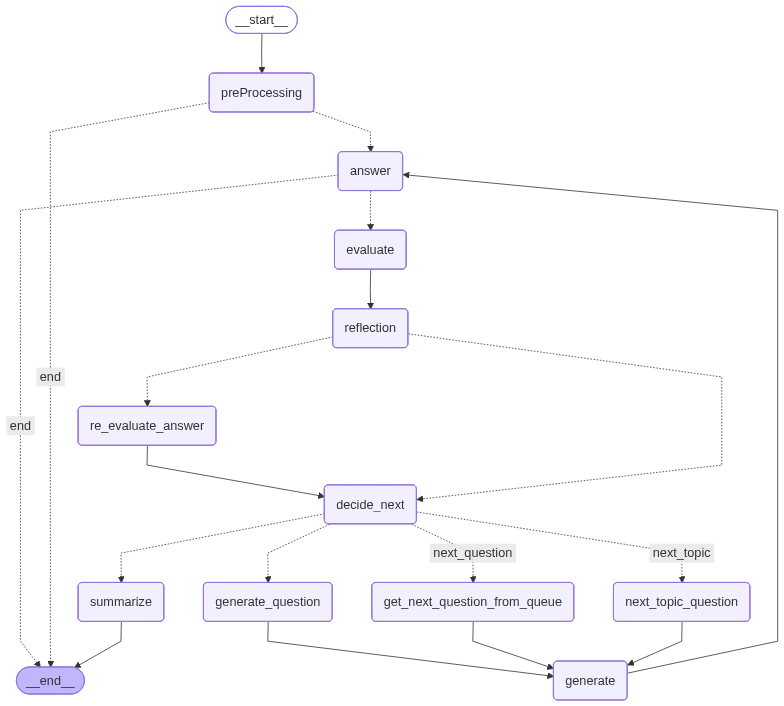

In [221]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("시각화 오류:", e)


## **4. 시스템 실행**

미션3에서 수행한 결과를 통합 테스트 해 봅시다.

### (1) 인터뷰 사전준비 작업

In [222]:
# 초기 상태 불러오기
state = initial_state.copy()

print("\n=== 🧭 면접 프로세스 시작 ===")

# Step 1. 이력서 분석
state = analyze_resume(state)
print("▶ 이력서 분석 완료")

# Step 2. 질문 전략 생성
if state["next_step"] == "generate_question_strategy":
    state = generate_question_strategy(state)
    print("▶ 질문 전략 생성 완료")

    # ✅ 질문 전략 보기 좋게 출력
    import pandas as pd
    df_strategy = pd.DataFrame(state["question_strategy"]["categories"])
    print("\n=== 면접 질문 전략 ===")
    print(state["question_strategy"]["summary"])  # 전체 요약
    display(df_strategy)


=== 🧭 면접 프로세스 시작 ===
▶ 이력서 분석 완료
▶ 질문 전략 생성 완료

=== 면접 질문 전략 ===
지원자는 머신러닝과 데이터마이닝에 대한 깊은 이해를 바탕으로 실무 경험을 쌓아온 신입 소프트웨어 엔지니어입니다. 면접에서는 경력과 경험, 커뮤니케이션 능력, 문제 해결력을 중심으로 지원자의 기술적 역량과 협업 능력을 검증할 예정입니다.


,category,question_direction,example_question
0,경력과 경험,"지원자가 KT AI 연구소에서의 인턴 경험과 관련 프로젝트에서 어떤 역할을 했는지,...",[KT AI 연구소에서 OCR 기반 문서 처리 시스템을 고도화하는 과정에서 어떤 기...
1,커뮤니케이션 능력,지원자가 팀 내에서의 협업 경험과 의사소통 방식에 대해 어떻게 생각하는지를 평가하여...,"[Git과 Docker를 활용한 협업 경험에 대해 설명해 주시고, 팀원들과의 의사소..."
2,문제해결력,지원자가 직면했던 문제를 어떻게 분석하고 해결했는지를 통해 판단력과 책임감을 평가할...,[프로젝트 진행 중 발생한 기술적 문제를 해결하기 위해 어떤 접근 방식을 사용했는지...


### (2) Agent 실행

In [223]:
# ==========================================
# 🚀 LangGraph 면접 Agent 실행 (Full Process)
# ==========================================

from tqdm import tqdm
import time

print("\n=== 🚀 면접 Agent 실행 시작 ===")

# 1️⃣ preProcessing 단계 실행
state = preProcessing_Interview(file_path)
if state.get("next_step") == "end":
    print("⚠️ preProcessing 단계에서 오류 발생, 종료합니다.")
else:
    print("▶ preProcessing 완료 — 초기 질문 전략 수립")

# 2️⃣ 3개 분야 × 2문항 = 6개 질문 가져오기
categories = state["question_strategy"].get("categories", [])
question_list = []
for cat in categories:
    qs = cat.get("example_question", [])
    # 질문 2개씩만 사용
    for q in qs[:2]:
        question_list.append({"topic": cat["category"], "question": q})

print(f"\n총 {len(question_list)}개의 초기 질문이 준비되었습니다 ✅")


=== 🚀 면접 Agent 실행 시작 ===
▶ preProcessing 완료 — 초기 질문 전략 수립

총 6개의 초기 질문이 준비되었습니다 ✅



🗣️ [1] 경력과 경험 질문
Q: KT AI 연구소에서 OCR 기반 문서 처리 시스템을 고도화하는 과정에서 어떤 기술적 도전이 있었고, 이를 어떻게 해결했는지 설명해 주실 수 있나요?
👤 답변 입력: KT AI 연구소에서는 다양한 서식의 비정형 문서를 자동으로 처리하기 위해 딥러닝 기반 OCR 엔진과 문서 레이아웃 분석 기술을 적용했습니다. 기술적 도전은 서식이 제각각이거나 스캔 품질이 낮은 문서에서 인식률이 떨어지는 것이었는데, 이를 해결하기 위해 이미지 전처리(기울기 보정·노이즈 제거) 와 서식별 모델 튜닝을 병행했습니다. 또한 OCR 이후 단계에서는 문서 파싱과 필드 추출 알고리즘을 도입해, 표·문단·이미지 등 복잡한 구조도 자동으로 인식하도록 했습니다. 그 결과, 문서 처리 속도가 크게 향상되고 인식 정확도가 높아져 수작업 검증이 대부분 자동화되었습니다.
85
▶ 평가 완료 → 다음 단계: end

🗣️ [2] 경력과 경험 질문
Q: AI 면접관 시스템과 교통량 예측 프로젝트에서 맡았던 구체적인 역할과 기여한 부분에 대해 말씀해 주세요.
👤 답변 입력: AI 면접관 시스템에서는 면접 시나리오 자동화 파이프라인 설계를 맡아, LangChain과 LangGraph를 활용해 질문 생성 → 답변 평가 → 피드백 생성이 순환되는 그래프 구조를 구현했습니다. 또한 LLM이 비정상 출력을 내는 경우를 대비해 예외 처리 및 디버깅 로깅 체계를 직접 설계해, 시스템 안정성을 높였습니다.  교통량 예측 프로젝트에서는 데이터 전처리와 모델 학습 파트를 담당했습니다. 도로별 교통량·기상·시간 데이터를 병합하고 시계열 특성을 반영하기 위해 LightGBM과 LSTM 모델을 비교 실험했습니다. 그 결과, 데이터 누락이 많은 환경에서도 평균 예측 오차(MAE)를 15% 이상 개선하며 모델의 신뢰도를 높였습니다.  이 두 프로젝트를 통해 데이터 기반 의사결정과 AI 자동화 설계 역량을 함께 길렀습니다.
85
▶ 평가 완료 → 다음 단계: end

🗣️ [3] 커뮤니케이션 능력 

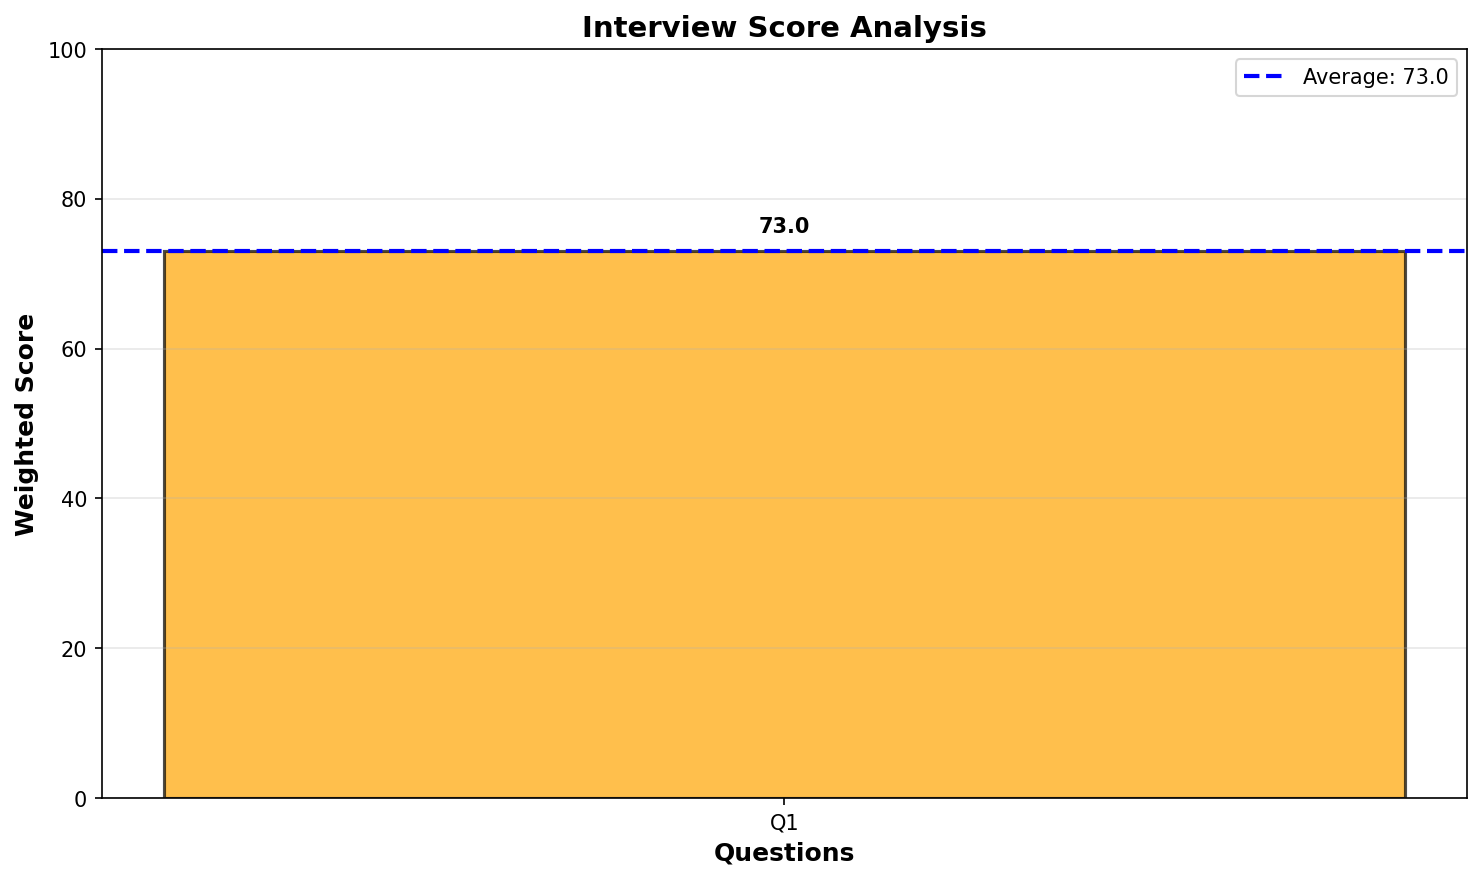


== 면접 종료 ==

✅ 면접 Agent 실행 종료 ✅


In [224]:
# 3️⃣ 각 초기 질문 처리 루프
for idx, q_info in enumerate(question_list, 1):
    print(f"\n==============================")
    print(f"🗣️ [{idx}] {q_info['topic']} 질문")
    print(f"Q: {q_info['question']}")

    # 사용자가 직접 답변 입력
    user_answer = input("👤 답변 입력: ").strip()

    # answer → evaluate → reflection → decide_next 순서로 실행
    state = update_current_answer(state, user_answer)
    state = evaluate_answer(state)
    state = reflect(state)
    state = decide_next_step(state)

    print(f"▶ 평가 완료 → 다음 단계: {state.get('next_step')}")

    # decide_next 결과가 generate라면 심화질문 수행
    if state.get("next_step") == "generate":
        print("\n💡 심화질문 단계로 진입합니다.")
        depth_count = 0

        while depth_count < 5:
            state = generate_question(state)
            print(f"\n🔍 심화질문 {depth_count+1}: {state['current_question']}")

            user_answer = input("👤 답변 입력: ").strip()

            state = update_current_answer(state, user_answer)
            state = evaluate_answer(state)
            state = reflect(state)
            state = decide_next_step(state)

            depth_count += 1

            if state.get("next_step") in ["next_topic", "end"]:
                print("💬 심화질문 종료, 다음 주제로 이동합니다.")
                break

print("\n=== 🧭 모든 질문 완료 ===")

# 4️⃣ 면접 요약 리포트
print("\n📊 최종 보고서 생성 중...")
time.sleep(1)
summarize_interview(state)
print("\n✅ 면접 Agent 실행 종료 ✅")
